In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as NN
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets

In [2]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [3]:
train_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.RandomHorizontalFlip(), # randomly flip and rotate
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

test_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [4]:
train_data = datasets.ImageFolder(
    root=r"C:\Users\VICTUS\Documents\Data-Science\.git\Flowers_data\dataset\train",
    transform=train_transform
)

test_data = datasets.ImageFolder(
    root=r"C:\Users\VICTUS\Documents\Data-Science\.git\Flowers_data\dataset\train",
    transform=test_transform
)

valid_data = datasets.ImageFolder(
    root=r"C:\Users\VICTUS\Documents\Data-Science\.git\Flowers_data\dataset\train",
    transform=test_transform
)

print('Num training images: ', len(train_data))
print('Num test images: ', len(test_data))
print('Num cv images: ', len(valid_data))

Num training images:  6552
Num test images:  6552
Num cv images:  6552


In [5]:
batch_size = 32
# Create data loaders.
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True)

loaders_scratch = {
    'train': train_dataloader,
    'test' : test_dataloader,
    'valid': valid_dataloader
}

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([32, 3, 128, 128])
Shape of y: torch.Size([32]) torch.int64


In [6]:
import json
f = open(r"C:\Users\VICTUS\Documents\Data-Science\.git\Flowers_data\cat_to_name.json")

category_name = json.load(f)
print(category_name)

{'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion flower', '2': 'hard-leaved pocket orchid', '54': 's

In [7]:
print(f"No. of categories: {len(category_name)}")

No. of categories: 102


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

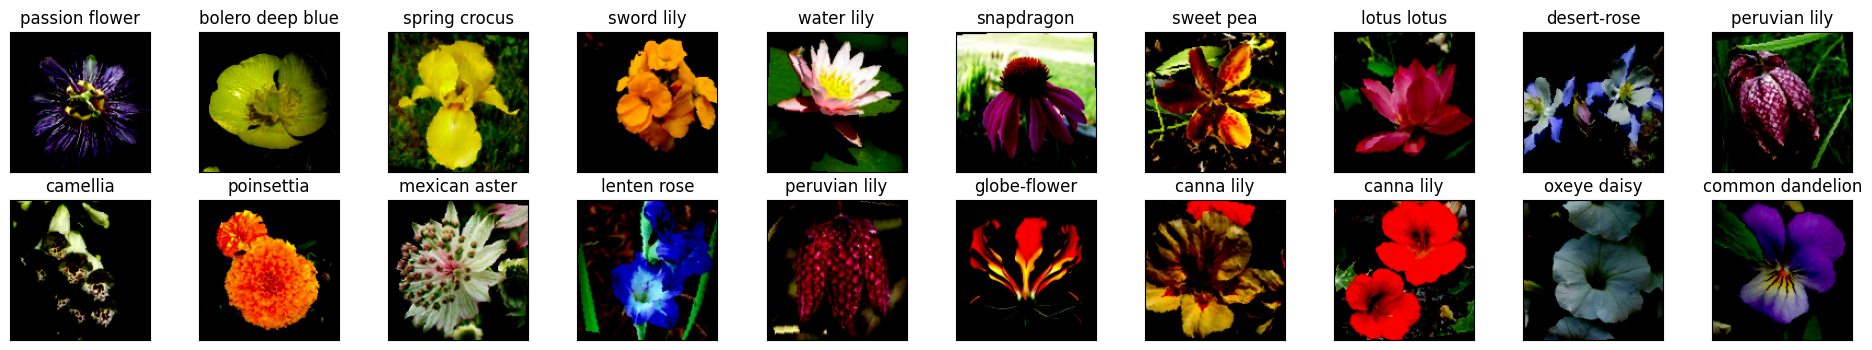

In [8]:
classes = ['cat','dog']
# visualize image
def imshow(img):
    plt.imshow(np.transpose(img,(1,2,0)))

# Obtain one batch of image
dataiter = iter(train_dataloader)
images, labels = dataiter.__next__()
images = images.numpy()

#plot the images in the batch

fig = plt.figure(figsize=(24,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    label = str(labels[idx].item())
    name = category_name.get(label)
    ax.set_title(name)

In [9]:
def conv_layer(in_channels, out_channels, kernel_size=4):
    layers = []
    layers.append(NN.ReLU())
    conv_layer = NN.Conv2d(in_channels, out_channels, kernel_size)
    layers.append(conv_layer)
    layers.append(NN.MaxPool2d(2, 2,ceil_mode=True))
    layers.append(NN.BatchNorm2d(out_channels))
    return NN.Sequential(*layers)

In [10]:
# CNN Architecture

class CnnNet(NN.Module):
    def __init__(self):
        super().__init__()
        self.conv = NN.Sequential(
                # 3 * 128 * 128
                conv_layer(3, 16),
                # 16 * 64 * 64
                conv_layer(16, 32),
                # 32 * 32 *32
                conv_layer(32, 64),
                # 64 * 16 * 16
                conv_layer(64, 128),
                # 128 * 8 * 8
                conv_layer(128, 256)
                # 256 * 4 * 4
        )
        self.linear = NN.Linear(2*2*256, 102)
        self.dropout = NN.Dropout(0.2)

    def forward(self, X):
        conv_output = self.conv(X)
        linear_input = self.dropout(conv_output.view(-1, 2*2*256))
        return self.linear(linear_input)

model = CnnNet()

if train_on_gpu:
    model.cuda()

model      

CnnNet(
  (conv): Sequential(
    (0): Sequential(
      (0): ReLU()
      (1): Conv2d(3, 16, kernel_size=(4, 4), stride=(1, 1))
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
      (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): ReLU()
      (1): Conv2d(16, 32, kernel_size=(4, 4), stride=(1, 1))
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
      (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Sequential(
      (0): ReLU()
      (1): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1))
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
      (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): Sequential(
      (0): ReLU()
      (1): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1))
      (2): MaxPool2d(ker

In [11]:
criterion = NN.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
torch.cuda.empty_cache()

In [13]:

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path, valid_loss_min=np.Inf):
    """returns trained model"""
    print('started train')    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            optimizer.zero_grad()            
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))            
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
                        
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss_min > valid_loss:
            valid_loss_min = valid_loss
            print('Validation loss decreased saving model.....')
            torch.save(model.state_dict(), save_path)

    # return trained model
    return model


model_scratch = train(10, loaders_scratch, model, optimizer, 
                      criterion, train_on_gpu, 'model_scratch.pt')

started train
Epoch: 1 	Training Loss: 3.436154 	Validation Loss: 3.079657
Validation loss decreased saving model.....
Epoch: 2 	Training Loss: 2.481832 	Validation Loss: 3.031883
Validation loss decreased saving model.....
Epoch: 3 	Training Loss: 2.027233 	Validation Loss: 2.029485
Validation loss decreased saving model.....
Epoch: 4 	Training Loss: 1.677600 	Validation Loss: 2.652555
Epoch: 5 	Training Loss: 1.397471 	Validation Loss: 1.555181
Validation loss decreased saving model.....
Epoch: 6 	Training Loss: 1.187411 	Validation Loss: 1.825147
Epoch: 7 	Training Loss: 1.005069 	Validation Loss: 1.457271
Validation loss decreased saving model.....
Epoch: 8 	Training Loss: 0.843001 	Validation Loss: 0.869564
Validation loss decreased saving model.....
Epoch: 9 	Training Loss: 0.748140 	Validation Loss: 0.839040
Validation loss decreased saving model.....
Epoch: 10 	Training Loss: 0.670826 	Validation Loss: 0.921846


In [14]:
# load the model that got the best validation accuracy
if torch.cuda.is_available():
    map_location = lambda storage, loc: storage.cuda()
else:
    map_location = 'cpu'
print(f"Map Loc: {map_location}")
model_scratch.load_state_dict(torch.load('model_scratch.pt', map_location=map_location))
model_scratch

Map Loc: <function <lambda> at 0x000002014C4C7C10>


CnnNet(
  (conv): Sequential(
    (0): Sequential(
      (0): ReLU()
      (1): Conv2d(3, 16, kernel_size=(4, 4), stride=(1, 1))
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
      (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): ReLU()
      (1): Conv2d(16, 32, kernel_size=(4, 4), stride=(1, 1))
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
      (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Sequential(
      (0): ReLU()
      (1): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1))
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
      (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): Sequential(
      (0): ReLU()
      (1): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1))
      (2): MaxPool2d(ker

In [15]:
def test(loaders, model, criterion, use_cuda):
    print('started testing')
    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)  
        if batch_idx%10==0:
            print('Batch {} Test Loss: {:.6f}\n'.format(batch_idx,test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model, criterion, train_on_gpu)

started testing
Batch 0 Test Loss: 0.632370

Batch 10 Test Loss: 0.572793

Batch 20 Test Loss: 0.483798

Batch 30 Test Loss: 0.504092

Batch 40 Test Loss: 0.516623

Batch 50 Test Loss: 0.508474

Batch 60 Test Loss: 0.517661

Batch 70 Test Loss: 0.513895

Batch 80 Test Loss: 0.512437

Batch 90 Test Loss: 0.519454

Batch 100 Test Loss: 0.508913

Batch 110 Test Loss: 0.503108

Batch 120 Test Loss: 0.499079

Batch 130 Test Loss: 0.495549

Batch 140 Test Loss: 0.496192

Batch 150 Test Loss: 0.489746

Batch 160 Test Loss: 0.489874

Batch 170 Test Loss: 0.491620

Batch 180 Test Loss: 0.493470

Batch 190 Test Loss: 0.494408

Batch 200 Test Loss: 0.501056


Test Accuracy: 85% (5597/6552)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

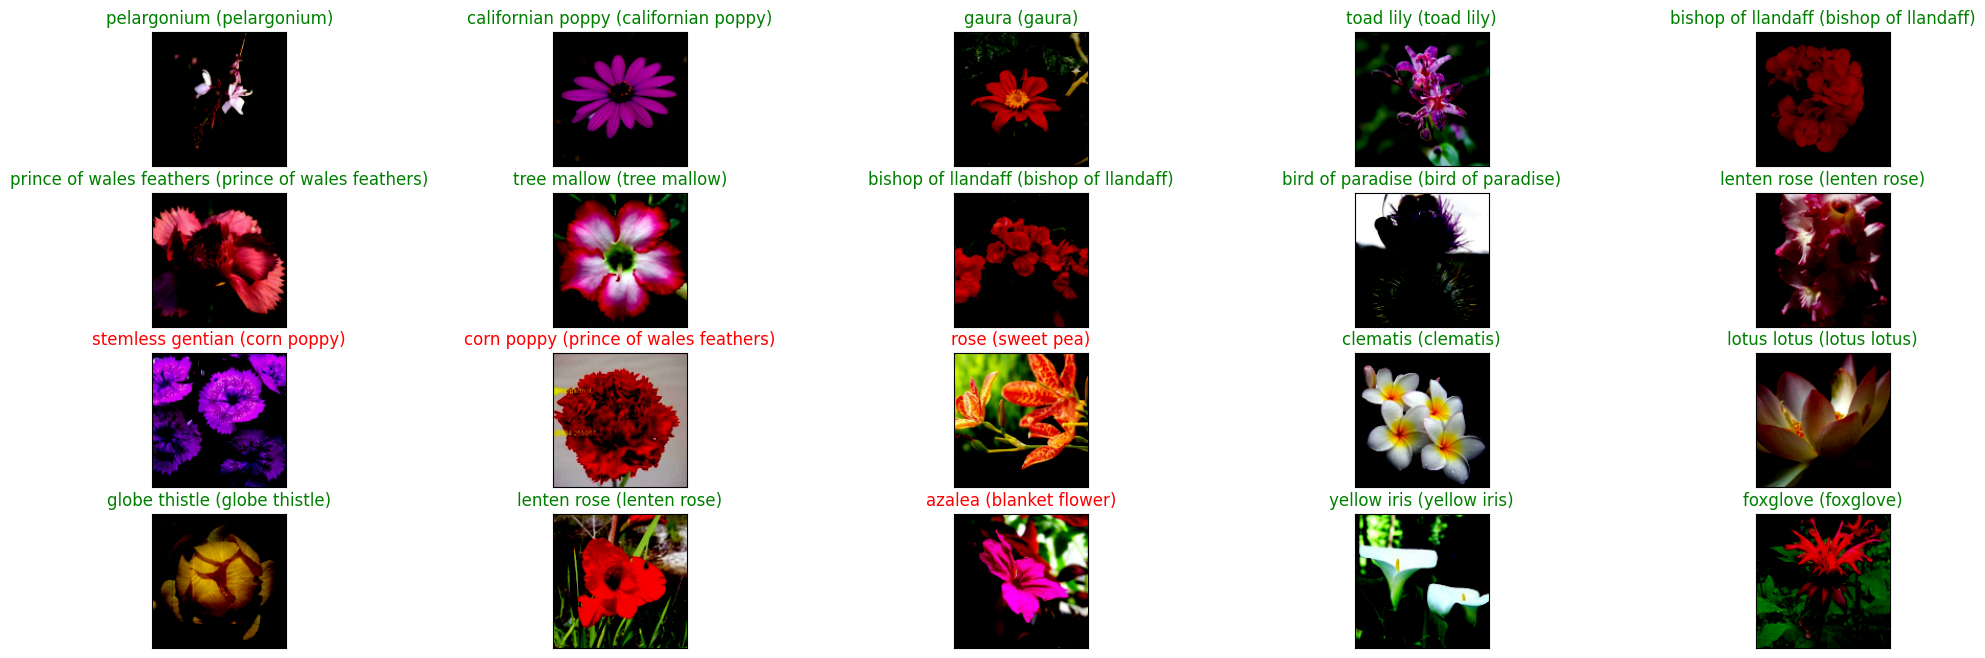

In [22]:
# obtain one batch of test images
dataiter = iter(test_dataloader)
images, labels = dataiter.__next__()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())
# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 8))
for idx in np.arange(20):
    ax = fig.add_subplot(4, 5, idx+1, xticks=[], yticks=[])
    imshow(images[idx] if not train_on_gpu else images[idx].cpu())

    pred_label = str(preds[idx])
    pred_name = category_name.get(pred_label)

    label = str(labels[idx].item())
    name = category_name.get(label)

    ax.set_title("{} ({})".format(pred_name, name),
                 color=("green" if pred_name==name else "red"))